# Import packages

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import scvelo as scv
import scanpy as sc
import anndata as ad
import os
import pandas as pd

In [12]:
from poisson_atac.experiments.atac_to_atac.experiment_runner import get_experiment
from poisson_atac.utils import load_experiment

In [36]:
from utils import cell_types, plot_regions

In [13]:
fig_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/Figure3'
save_path = '/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/biological_analysis/'

In [14]:
scv.set_figure_params()
sc.settings.figdir = os.path.join(fig_path)

# Load gene expression

In [15]:
gex_data_path = os.path.join('/lustre/groups/ml01/workspace/laura.martens/atac_poisson_data/data', 'neurips', 'phase2-private-data/common/openproblems_bmmc_multiome_phase2', 'openproblems_bmmc_multiome_phase2.manual_formatting.output_rna.h5ad')

In [18]:
adata_gex = ad.read(gex_data_path)

## Load annotation

In [22]:
annotation_great = pd.read_csv(os.path.join(save_path, 'annotation', 'great_regdom_annotation.csv'), index_col=0)

In [23]:
annotation_great.index = annotation_great.Chromosome + '-' + annotation_great.Start.astype(str) + '-' + annotation_great.End.astype(str)

# Load models

In [24]:
model_hash =  {'binaryvi': 'a5f0eb37a267cd1147021ae89f6de2fa', 'peakvi':'b3feda37c38d60b1e99b4c279240ba2e', 'poissonvi': 'f956cc1e4780c256e437a37c8bc1935c'} # the best models according to average precision

## Binary VI

In [25]:
_, binaryvi, _ = load_experiment('atac_to_atac', model_hash['binaryvi'], get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


2022-12-14 17:28:03 (INFO): Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-12-14 17:28:03 (INFO): Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
2022-12-14 17:28:03 (INFO): Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


BinaryVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=60, bias=True)
    (var_encoder): Linear(in_features=341, out_features=60, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Poisson VI

In [26]:
_, poissonvi, _ = load_experiment('atac_to_atac', model_hash['poissonvi'], get_experiment)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment
PoissonVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=100, bias=True)
    (var_encoder): Linear(in_features=341, out_features=100, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=11

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

# Compute normalized accessibility

In [27]:
correlations = pd.read_csv(os.path.join(save_path, 'correlations_size_factor_subset.csv'), index_col=0)

In [28]:
correlations = correlations[correlations.pvalue < 0.05].sort_values('correlation', ascending=False)

In [29]:
regions = correlations.head(30).index.to_list()

In [30]:
m_size_factor = poissonvi.adata.obs.size_factor.median()

In [31]:
acc = poissonvi.get_accessibility_estimates(
            return_numpy=False,
            n_samples=1,
            library_size=m_size_factor,
    region_list=regions
        )

In [32]:
acc_binary = binaryvi.get_accessibility_estimates(
            return_numpy=False,
            n_samples=1, 
            library_size=m_size_factor,
            logit=False,
    region_list=regions
        )

In [34]:
adata = poissonvi.adata.copy()

## Check which cell_types express the gene

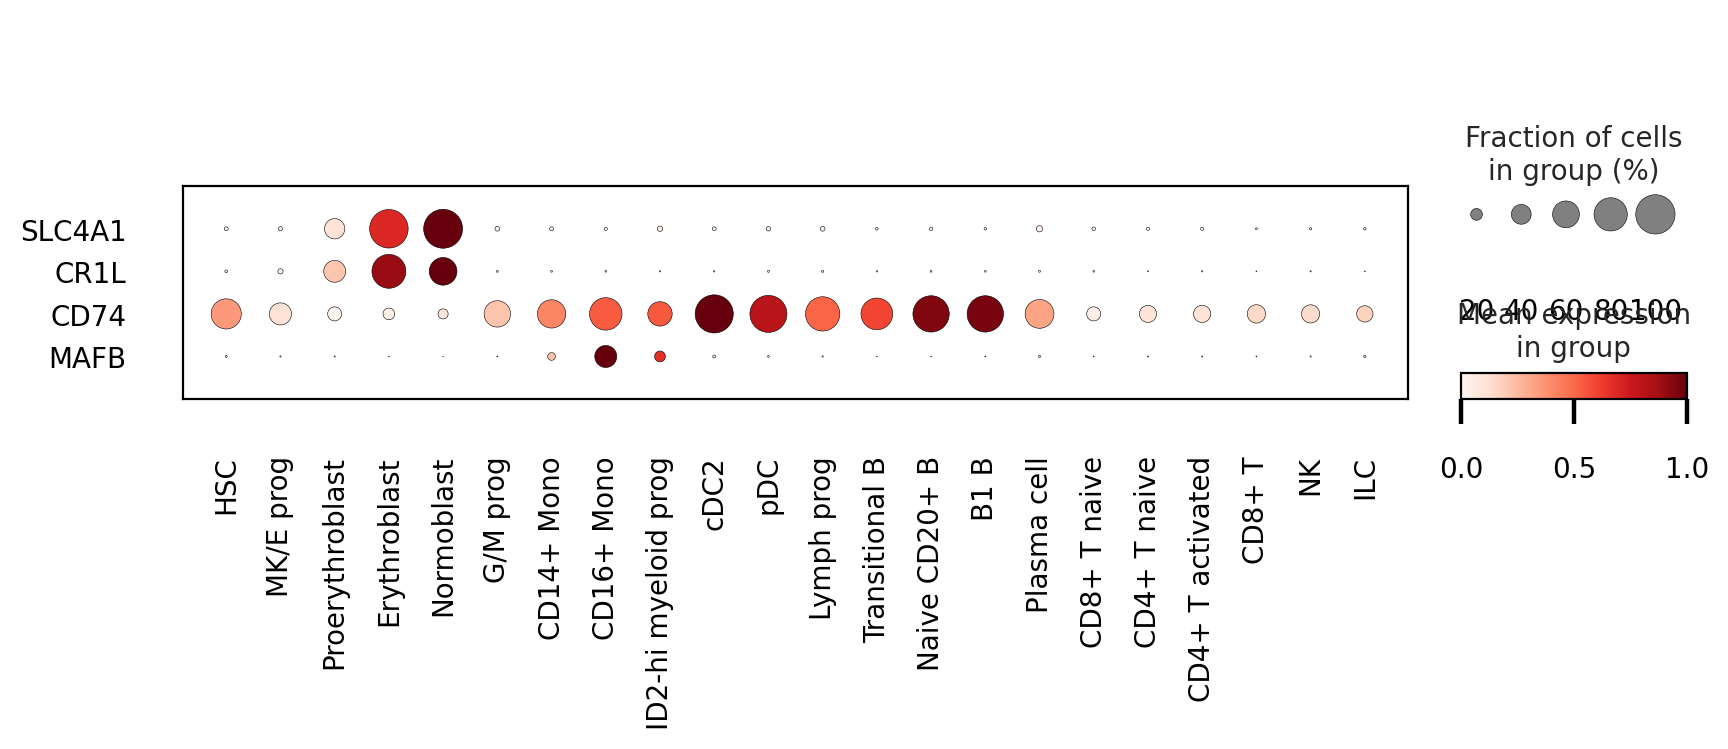

In [35]:
adata_gex.obs.cell_type = pd.Categorical(adata_gex.obs.cell_type, categories=cell_types)
sc.pl.dotplot(adata_gex, var_names=["SLC4A1", "CR1L", "CD74", "MAFB"], groupby='cell_type', standard_scale='var', swap_axes=True, save='_markers.png')

## Plot regions

CR1L


2022-12-14 18:05:25 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-12-14 18:05:30 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


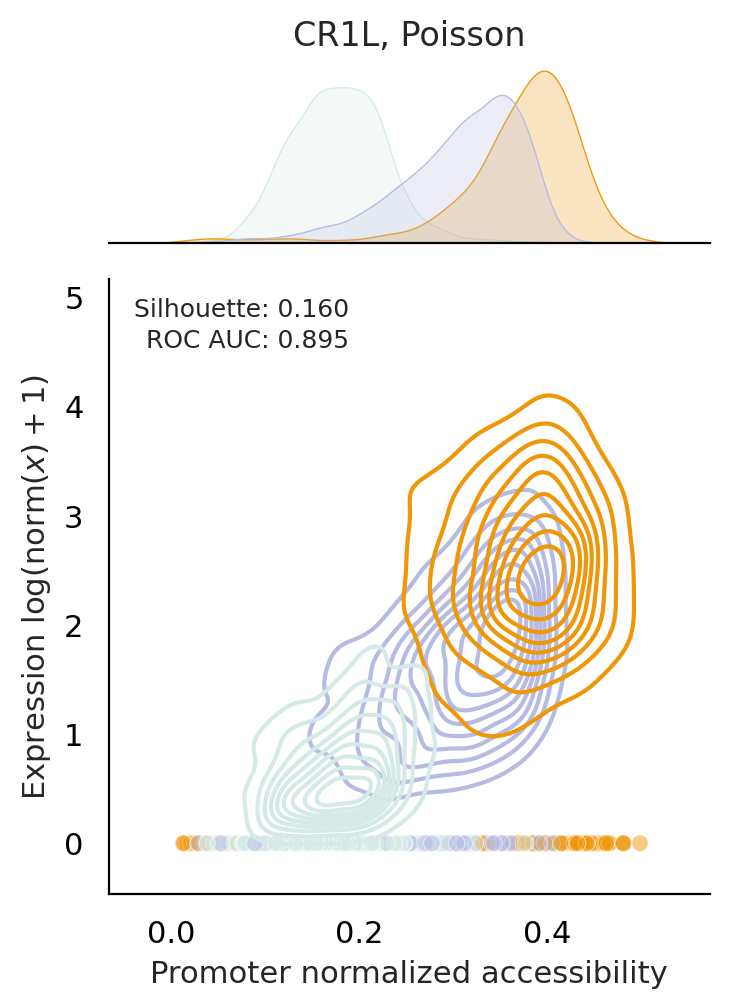

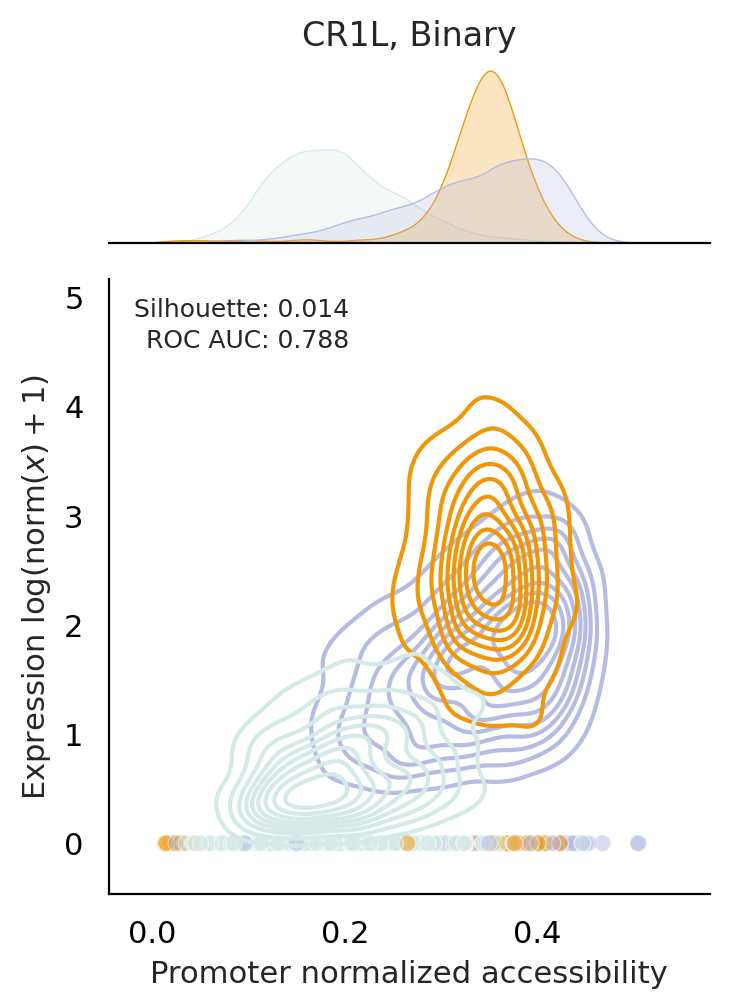

In [39]:
region = 'chr1-207644614-207645499'
plot_regions(region=region, correlation=correlations, adata=adata, adata_gex=adata_gex, acc=acc, acc_binary=acc_binary, cell_types = ['Proerythroblast', 'Erythroblast', 'Normoblast'], save_path=fig_path)

SLC4A1


2022-12-11 21:41:25 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-12-11 21:41:33 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


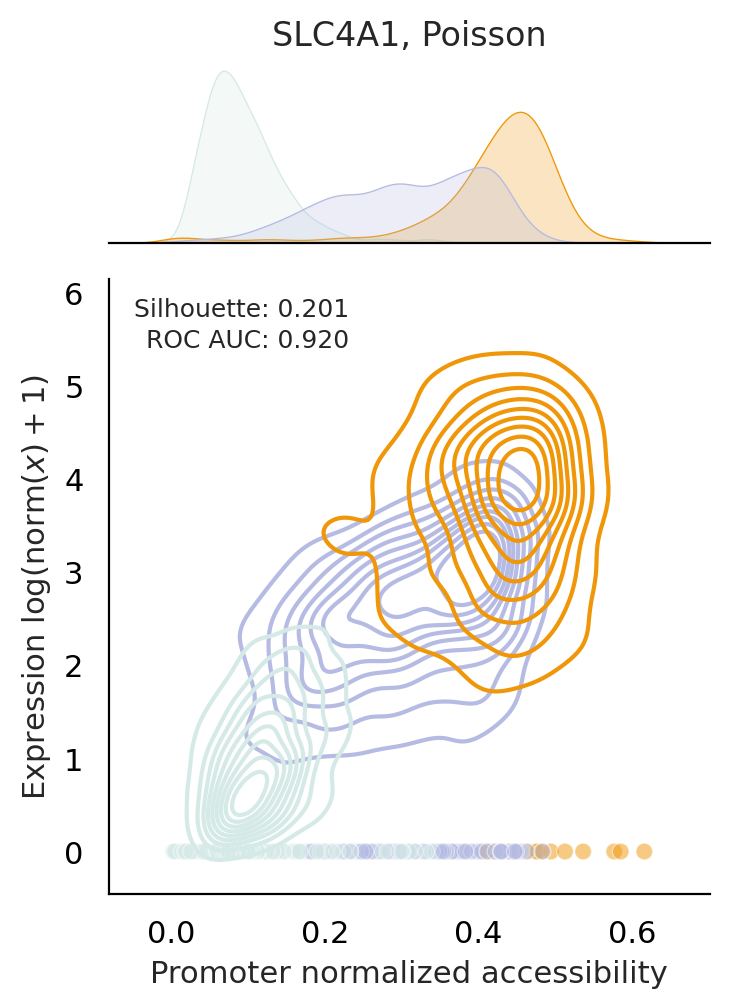

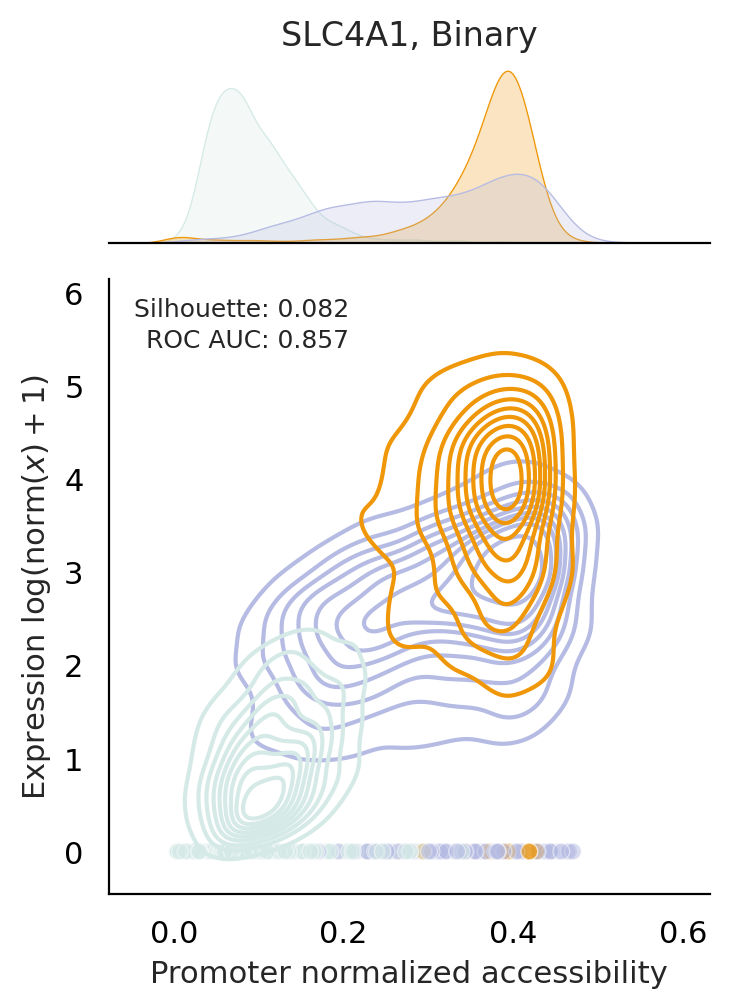

In [ ]:
region = 'chr17-44267801-44268699'
plot_regions(region=region, correlation=correlations, adata=adata, adata_gex=adata_gex, acc=acc, acc_binary=acc_binary, cell_types = [ 'Proerythroblast', 'Erythroblast', 'Normoblast'], save_path=fig_path)

MAFB


2022-12-11 21:41:38 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-12-11 21:41:44 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


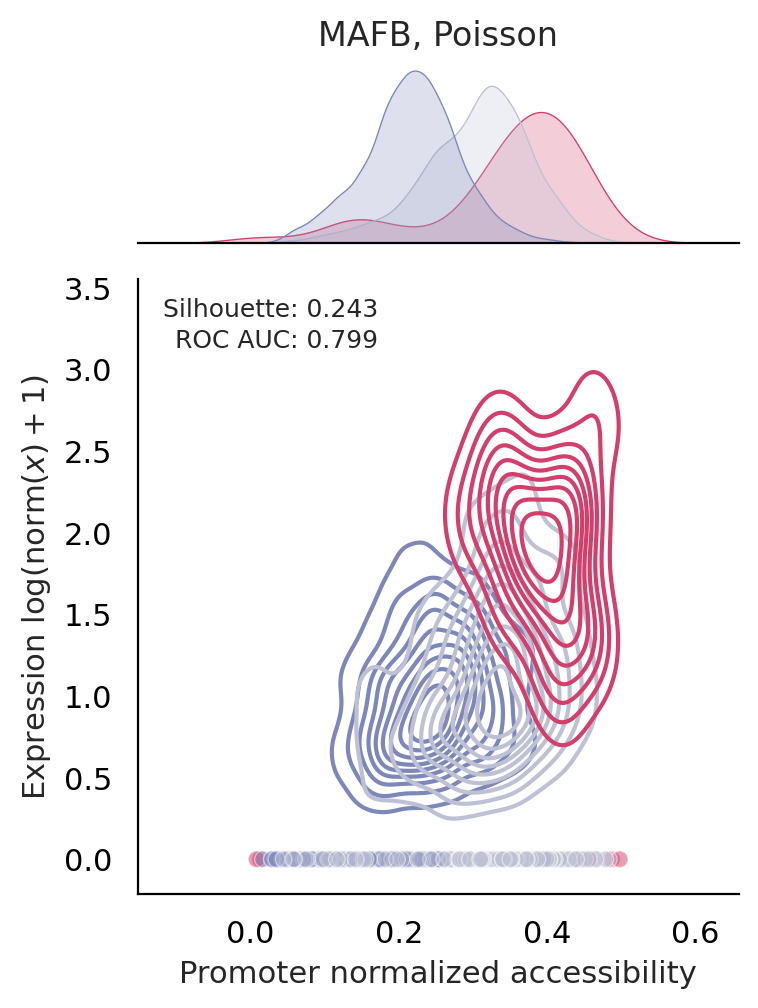

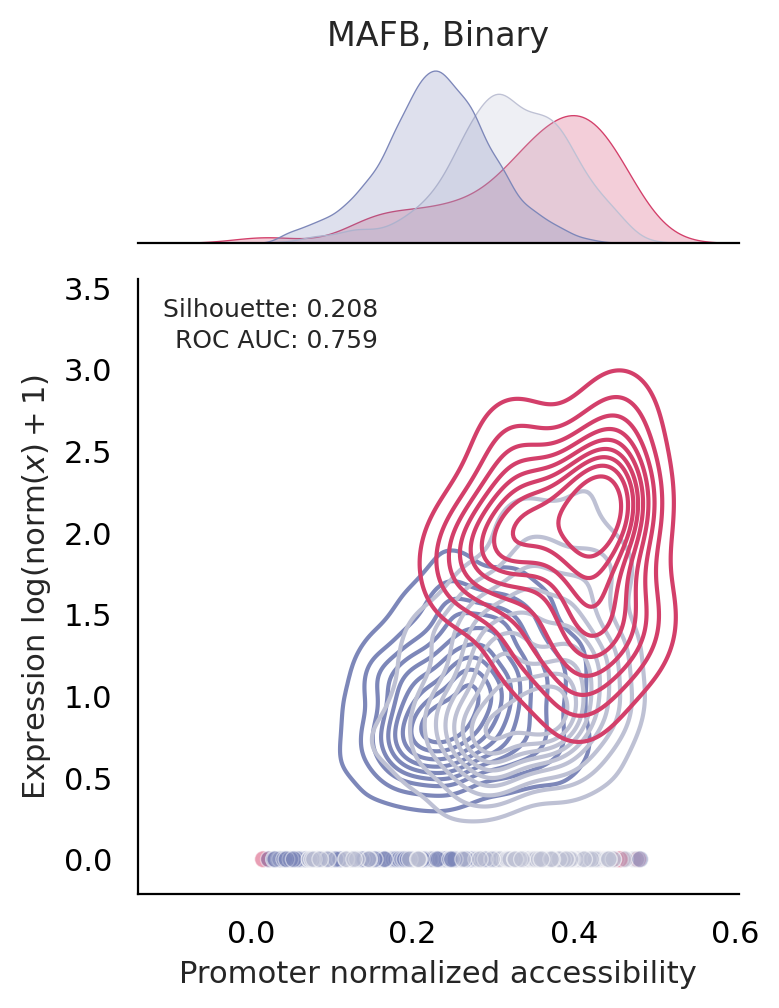

In [143]:
region = 'chr20-40688852-40689723'
plot_regions(region=region, correlation=correlations, adata=adata, adata_gex=adata_gex, acc=acc, acc_binary=acc_binary, cell_types = [ 'CD14+ Mono', 'CD16+ Mono', 'ID2-hi myeloid prog'], save_path=fig_path)

CD74


2022-12-11 21:41:50 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-12-11 21:41:53 (WARNING): No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


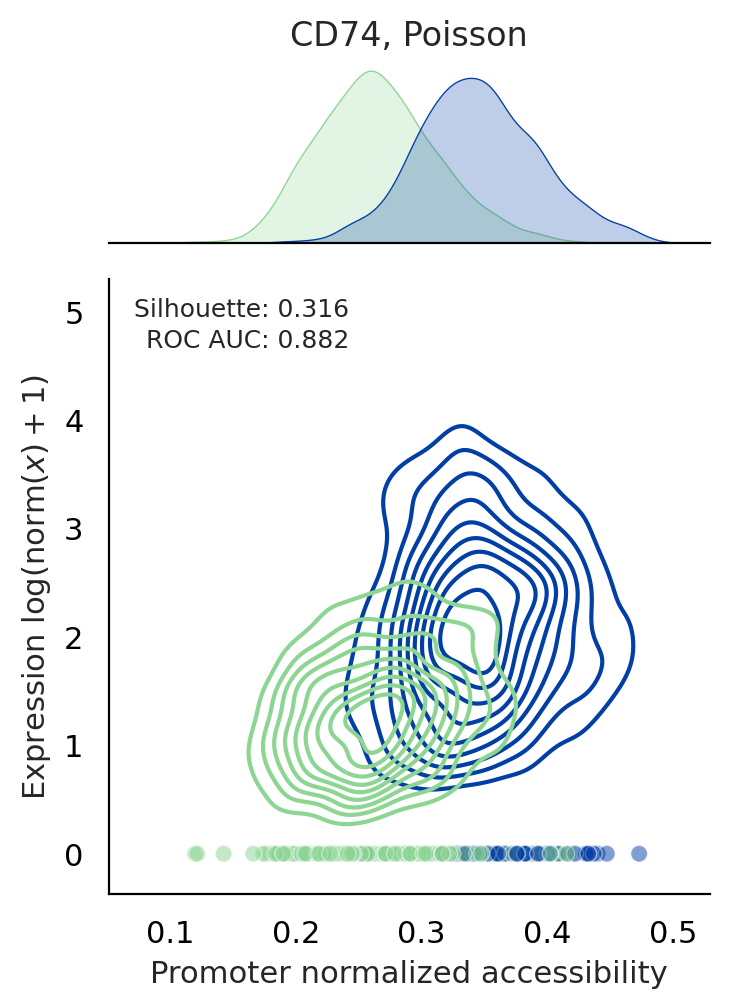

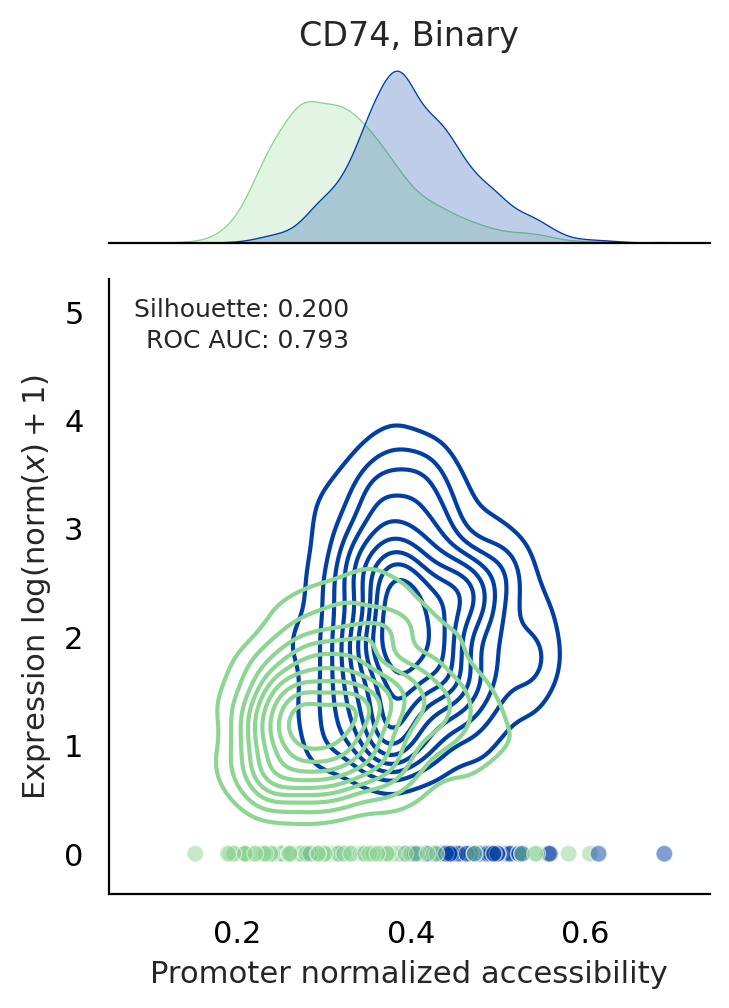

In [144]:
region = 'chr5-150412442-150413366'
plot_regions(region=region, correlation=correlations, adata=adata, adata_gex=adata_gex, acc=acc, acc_binary=acc_binary, cell_types = ['Lymph prog', 'B1 B'], save_path=fig_path)